# Recommendation Systems

In this documentation, we will create a recommendation system for **restaurants** using [collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF). The general structure of a recommendation system is that there are users and there are items. Users express explicit or implicit preferences towards certain items. CF thus relies on users' past behavior to make recommendations to them.

There are two primary approaches to CF: neighboorhood and latent factor model. The former is concerned with computing the relationships between items or between users. In the latter approach you have a model of hidden factors through which users and items are transformed to the same space. For example, if you are rating movies we may transform items into genre factors, and users into their preference for a particular genre.

Factor models generally lead to more accurate recommenders. One of the reasons for this is the sparsity of the item-user matrix. Most users tend to rate barely one or two items. Latent factor models are more expressive, and fit fewer parameters. However, neighborhood models are more prevalent, as they have an intuitive aspect that appeals to users(if you liked this you will like that) and online(a new preference can be incorporated very quickly).

Most recommenders today combine neighboorhood CF with model based CF, and SVD based matrix factorization approaches.

To see the example of a simple beer recommender, go [here](http://nbviewer.ipython.org/20a18d52c539b87de2af). This homework is inspired by the one there but we go after food instead, and go deeper into the problem of making recommendations.

## Environment Settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Description of the data set

The data set has been extracted from the Yelp Phoenix restaurants dataset. It is available [here](https://dl.dropboxusercontent.com/u/75194/bigdf.csv).

The data frame is a frame of reviews, where every user has only one review for each restaurant.

Variables dictionary:

- 'stars': (star rating, integer 1-5)
- 'date': (date, formatted like '2011-04-19')
- 'review_id': (unique id for the review)
- 'business_id': (a unique identifier for this business),
- 'biz_name': (the full business name),
- 'latitude': (latitude),
- 'longitude': (longitude),
- 'business_review_count': (review count for the restaurant[this is a repeated field for all reviews of the restaurant]),
- 'categories': [(localized category names)],
- 'business_avg': (average stars over all users reviews for business[this is a repeated field for all reviews of the restaurant]).
- 'user_id': (unique user identifier),
- 'user_name': (first name, last initial, like 'Matt J.'),
- 'user_review_count': (count of restaurants reviewed by user[this is a repeated field for all reviews by the user]),
- 'user_avg': (floating point average of users reviews over all businesses, like 4.31[this is a repeated field for all reviews by the user]).

In [2]:
fulldf = pd.read_csv("bigdf.csv")
fulldf.head(2)

user_id             business_id                 date  \
0  rLtl8ZkDX5vH5nAx9C3q5Q  9yKzy9PApeiPPOUJEtnvkg  2011-01-26 00:00:00   
1  SBbftLzfYYKItOMFwOTIJg  9yKzy9PApeiPPOUJEtnvkg  2008-05-04 00:00:00   

                review_id  stars  usefulvotes_review user_name  \
0  fWKvX83p0-ka4JS3dc6E5A      5                   5     Jason   
1  DASdFe-g0BgfN9J2tanStg      5                   1  Jennifer   

                          categories            biz_name   latitude  \
0  [Breakfast & Brunch, Restaurants]  Morning Glory Cafe  33.390792   
1  [Breakfast & Brunch, Restaurants]  Morning Glory Cafe  33.390792   

    longitude  business_avg  business_review_count  user_avg  \
0 -112.012504       3.87156                    109  3.796954   
1 -112.012504       3.87156                    109  3.473684   

   user_review_count  
0                197  
1                 57

In [3]:
fulldf.shape

(149319, 15)

## Our Recommender

To motivate our recommendation system, consider the follwing example. Let's pretend we are in Boston for a second. Lets say the average rating of restaurants here by all the users is 3.5. Sandrine's at Harvard square is better than an average restaurant, so it tends to be rated 0.5 stars above the average (over all the users). However, you are a curmudgeon, who tends to rate 0.2 stars below the average. Then a baseline estimate for the recommendation for Sandrine's, for you, is 3.5+0.5-0.2=3.8.

These baseline estimates thus adjust the data by accounting for the systematic tendencies for some users who give higher ratings than others, and for some restaurants to recieve higher ratings than others. We can write the baseline estimate $\hat Y_{um}^{baseline}$ for an unknown rating $Y_{um}$ for user $u$ and restaurant or business $m$ as:

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u0} + \hat \gamma_{m0} $$

where the unknown parameters $\theta_{u0}$ and $\gamma_{m0}$ indicate the deviations, or biases, of user $u$ and item $m$, respectively, from some intercept parameter $\mu$. (The reason for the strange notation with 0s will become clear in Problem 3)

Notice that the $\theta_{u0}$ and $\gamma_{m0}$ are parameters which need to be fit. The simplest thing to start with, and something we will do for Problems 1 and 2 (but not 3), is to replace them by their "mean" estimates from the data. Thus:

$$ \hat Y^{baseline}_{um} = \bar Y + (\bar Y_u - \bar Y) + (\bar Y_m - \bar Y)$$

where $\bar Y_u$ = `user_avg`, the average of all a user $u$'s ratings and $\bar Y_m$ = `business_avg`, the average of all ratings for a restaurant $m$. $\bar Y$ is the average rating over all reviews.

The final two terms correspond to the user-specific and item-specific bias in ratings, that is, how their ratings tend to systematically diverge from the global average. This is the simplest possible way to predict a rating, based only on information about *this* user and *this* restaurant.

Can we do a better job of predicting the rating $Y_{um}$ user $u$ would give to restaurant $r$? According to the central dogma of CF, we ought to be able to use the responses of *similar* users regarding *similar* restaurants to get a better prediction. 

We can make an estimate of $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $s^{k}(m)$ is the $k$ neighbor items of item $m$ based on some pooling criterion, for example, those items which have been rated by user $u$.

In the next two problems, we will focus on using similar restaurants, or the item neighborhood.
To do this, we compute a *similarity measure* $s_{mj}$ between the $m$th and $j$th items. This similarity might be measured via [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity), [pearson co-efficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) or using other distance based measures. Here we shall use the Pearson coefficient. This measures the tendency of users to rate items similarly. Since most ratings are unknown, it is computed on the "common user support" (`n_common`), which is the set of common raters of both items. 

In the first problem we shall set $S$ to the global neighborhood of the item, and in the second we shall set it to those items which have been rated by user $u$.

## Q1. Writing a simple "global" recommender

Now we have a way to pool information between similar restaurants to try to predict a user's recommendation. But how do we choose the neighborhood to pool over? We begin with the simplest choice. We calculate the similarity between items using their entire common user support, and rank the nearest neighbors of an item by this similarity. We call this a "global" recommender because it assumes that every user perceives the similarity between restaurants in the same way. Later on, we will implement a more specific recommender that pools information based on which items seem the most similar *to this user*.

The global recommender does have the advantage of dealing with the possible sparsity of the user's rated items, but also the disadvantage of giving one answer for all users, without taking the user's preferences into account. This is a classic case of bias-variance tradeoff.

Lets implement this simpler global recommender first.

### Exploratory Data Analysis

**1.1** Visualize the sparsity of the full data set by plotting two histograms of the review count  grouped by the `user_id` and `business_id` respectively. Are there more users or more businesses?

Remove borders. 
http://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame

In [4]:
# function to remove unnecessary borders and ticks
def remove_border( ax, top = False, left = True, right = False, bottom = True ) :
    
    ax.spines['top'].set_visible(top)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    
    # turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    # now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()   

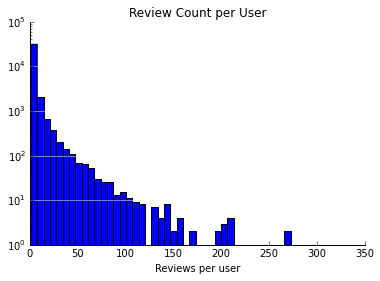

In [5]:
# count the review_id grouped by user_id
urc = fulldf.groupby("user_id").review_id.count()
ax = urc.hist( bins = 50, log = True )
remove_border(ax)
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid( axis = 'y', color = 'white', linestyle = '-' )
plt.title("Review Count per User")
plt.show()

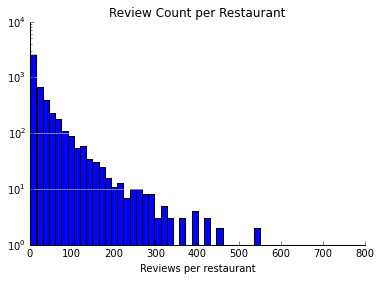

In [6]:
# count the review_id grouped by business_id
brc = fulldf.groupby("business_id").review_id.count()
ax = brc.hist( bins = 50, log = True )
remove_border(ax)
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid( axis = 'y', color = 'white', linestyle = '-' )
plt.title("Review Count per Restaurant")
plt.show()

In [7]:
print( "Number of Reviews", fulldf.shape[0] )
print( "Number of users", fulldf.user_id.unique().shape[0] )
print( "Number of Businesses", fulldf.business_id.unique().shape[0] )

('Number of Reviews', 149319)
('Number of users', 34789)
('Number of Businesses', 4503)


As we can see there're more users than businesses.

**1.2** Compute the average rating of reviews in the data set and a histogram of all the ratings in the dataset.

('Mean stars over all reviews:', 3.7414126802349332)


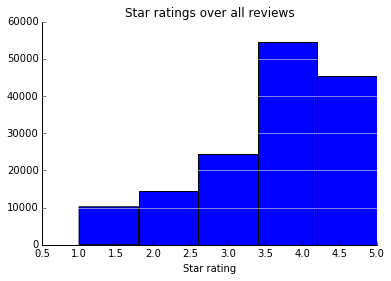

In [8]:
print( "Mean stars over all reviews:", fulldf.stars.mean() )
ax = fulldf.stars.hist( bins = 5 )
remove_border(ax)
plt.xlabel("Star rating")
plt.grid(False)
plt.grid( axis = 'y', color = 'white', linestyle = '-' )
plt.title("Star ratings over all reviews");
plt.show()

**1.3** Create a smaller data set in dataframe `smalldf` by looking for those businesses with more than 150 reviews and users with more than 60 reviews. Include all the columns that were there in the parent dataframe. Since we have created a subset of the data set, we have to recalculate the averages.

In [9]:
import recommendation as r
# reload(r)

In [10]:
smalldf = fulldf[ ( fulldf.user_review_count > 60 ) & ( fulldf.business_review_count > 150 ) ]
smalldf = r.recompute_frame( df = smalldf ) # recompute the averages
smalldf.head(2)

user_id             business_id                 date  \
0  rLtl8ZkDX5vH5nAx9C3q5Q  eIxSLxzIlfExI6vgAbn2JA  2011-05-12 00:00:00   
1  C6IOtaaYdLIT5fWd7ZYIuA  eIxSLxzIlfExI6vgAbn2JA  2011-04-12 00:00:00   

                review_id  stars  usefulvotes_review user_name  \
0  z4G1g3VcdfigCUtVDFRL1w      4                   5     Jason   
1  480M-xDpRaA1gCVCqIG4WA      4                  14     Daren   

                                         categories                  biz_name  \
0  [Burgers, Hot Dogs, American (New), Restaurants]  Lobbys Beef Burgers Dogs   
1  [Burgers, Hot Dogs, American (New), Restaurants]  Lobbys Beef Burgers Dogs   

   latitude   longitude  business_avg  business_review_count  user_avg  \
0  33.39477 -111.908894          4.04                     25  3.709677   
1  33.39477 -111.908894          4.04                     25  4.000000   

   user_review_count  
0                 62  
1                 15

How does this compare to the parent data set, in terms of size and sparsity? Once again, plot histograms of the review count grouped by user, and by the review count grouped by business, respectively, and describe the results

Total Number of Reviews 6165
Users in this set 240 Restaurants 172


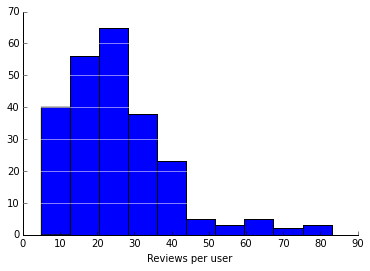

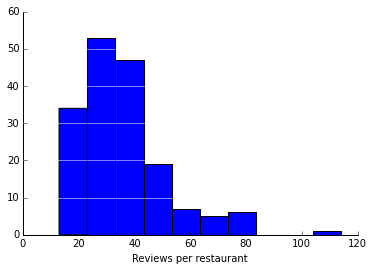

In [11]:
print "Total Number of Reviews", smalldf.shape[0]
print "Users in this set", smalldf.user_id.unique().shape[0], "Restaurants", smalldf.business_id.unique().shape[0]
plt.figure()
ax = smalldf.groupby('user_id').review_id.count().hist()
remove_border(ax)
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.figure()
ax = smalldf.groupby('business_id').review_id.count().hist()
remove_border(ax)
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')

 As we made a very specific cut on the data set, making sure we had those businesses with greater than 150 reviews, and those users with more than 60 reviews, this data set is not as sparse as the full one, with a range in both graphs where the histogram is somewhat flat rather than steeply declining.

**1.4** Compute histograms of the average user rating in the smaller data set, and the average business rating in the smaller data set. Print the overall mean.

3.86763990268


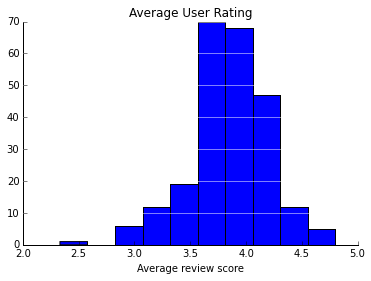

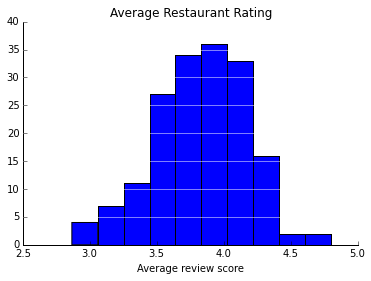

In [12]:
print smalldf.stars.mean()

plt.figure()
avg_ratings_by_user = smalldf.groupby('user_id').stars.mean()
ax = avg_ratings_by_user.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid(axis = 'y', color = 'white', linestyle = '-')
plt.title("Average User Rating")
plt.show()

avg_ratings_by_biz = smalldf.groupby('business_id').stars.mean()
ax = avg_ratings_by_biz.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid( axis = 'y', color = 'white', linestyle = '-')
plt.title("Average Restaurant Rating")
plt.show()

### Common Support

Lets now make a histogram of the common user support ( the number of the same reviewers ) of each pair of restaurants on the smaller set, and print the mean. Pay attention to the code, as you will use parts of it later. (This code takes a bit of time to run, so be patient).

The common support is an important concept, as for each pair of restaurants, its the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable.

In [13]:
restaurants = smalldf.business_id.unique()
supports = []
for i, rest1 in enumerate(restaurants):
    for j, rest2 in enumerate(restaurants):
        if i < j :
            rest1_reviewers = smalldf[ smalldf.business_id == rest1 ].user_id.unique()
            rest2_reviewers = smalldf[ smalldf.business_id == rest2 ].user_id.unique()
            # using set and intersection to find similar reviewers
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append( len(common_reviewers) )

Mean support is: 6.84679722562


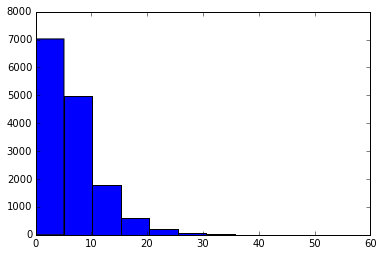

In [14]:
print "Mean support is:", np.mean(supports)
plt.hist(supports)
plt.show()

As you can see, even though we chose a subset of the dataframe in which every restaurant had 150 reviews and every user had atleast made 60, the common support of most pairs of restaurants is really low, indeed less than 10!

### Making a database of similarities

We now move to calculating a global database of pairwise restaurant similarities, which is to create a database of the similarities for each pair of restaurants. The class `Database` is initialized in its constructor by taking a dataframe of reviews as its arguments. The method `recommender` iterates over every possible pair of business_ids in the dataframe and calculates the database with similarities and common supports. 

Then the `get` method on the `Database` can be used to retrieve the similarity for two business ids.

**Note: **

When calculating similarities, users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

Even though each reviewer uses the same 5-star scale when rating restaurants, comparing two users by comparing their raw user ratings can be problematic. Consider a user whose average rating is 2. This is a curmudgeonly user. Consider another whose average rating is 4. This is a rather enthusiastic one. How should we compare a 3 rating by the curmudgeonly one to a 5 rating of the enthusiastic one?

It is for this purpose that we must subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants.

If there is no common support (`n_common=0`), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual restaurant rating variance is 0, such as in the case where there is only one common reviewer (`n_common=1`), we return the `NaN` that the scipy `pearsonr` returns and also converts it to 0.

In [15]:
# .recommend trains the algorithm
db = r.DataBase( df =  smalldf )
db.recommend()

In [16]:
# test by passing in two business id
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

### K-Nearest restaurants (in similarity)

We are now going to find the k-nearest restaurants to a given restaurant based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there is just one common reviewer, and where there are 40. In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

To control the effect of small common supports, we can **shrink** our pearson co-efficients. We shall do this by using the "regularization" parameter `reg`:

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg}$$

where $N_{common}$ (`n_common`) is the common reviewer support and $\rho_{ij}$ is the pearson co-relation coefficient.

Recall the notions of regularization introduced in class. We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot.

A good value of the regularizer is intuitively one that doesn't affect the similarity when the common support is high ~10, but has a large effect when the support is small. In this case, values of 2-4 are good. Usually, the value of `reg` is determined using cross-validation, but for the sake of simplicity we will generally set it to 3.

We define a function `shrunk_sim` which takes the `sim` and `n_common` obtained from the database, and shrinks the similarity down using the regularizer `reg`.

In [17]:
# Written in the Database class

**1.6** Now we can move to writing a `knearest` function, which finds the `k` nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are global over the entire set of restaurants, as opposed to being restricted to the restaurants a user has reviewed(we shall do that in the next problem). Thus, this is an expensive function!

Write a `knearest` that returns a *k-length sorted list* of 3-tuples each corresponding to a restaurant. The tuple structure is `(business_id, shrunken similarity score, common support)` where the similarity score and common support are with respect to the restaurant whose neighbors we are finding, and the `business_id` is the id of the "nearby" restaurant found. The nearby restaurants are found from a supplied numpy array of restaurants `set_of_restaurants`. The spec for the function is given below. HINT: use `itemgetter` from the `operator` module to do the sorting.

In [18]:
# Written in the Database class

### Ok it's time to recommend!

We first provide functions to look up a business name given a business id, and a username given a user id. Then choose the two very different businesses in the dataframe.

In [19]:
# convert to np.array type to extract the values, or else pandas will obtain the match by index
# where [0] may not work

# Written in the Database class as staticmethods
def lookup_business_name( df, biz_id ):
    return df['biz_name'][ df['business_id'] == biz_id ].values[0]
def lookup_user_name( df, user_id ):
    return df['user_name'][ df['user_id'] == user_id ].values[0]

In [20]:
# test
biz_id1 = "eIxSLxzIlfExI6vgAbn2JA"
biz_id2 = "L-uPZxooP_ziXCtRrWi8Pw"
print biz_id1, db.lookup_business_name( df = smalldf, biz_id = biz_id1 )
print biz_id2, db.lookup_business_name( df = smalldf, biz_id = biz_id2 )

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


#### Get top matches

Its now time to answer the question: "if you liked this, you might also like these". We use our `biz_id1` and `biz_id2` to compute the `k = 7` nearest neighbors with a regularization of 3. We print these top 7 matches names, along with their similarity coefficient and common support.

In [21]:
tops = db.knearest( biz_id1, smalldf.business_id.unique(), k = 7, reg = 3.0 )
print "For ", db.lookup_business_name( df = smalldf, biz_id = biz_id1 ), ", top matches are:"
for i, ( biz_id, sim, nc ) in enumerate(tops):
    print i, db.lookup_business_name( df = smalldf, biz_id = biz_id ), "| Sim", sim, "| Support", nc

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [22]:
tops = db.knearest( biz_id2, smalldf.business_id.unique(), k = 7, reg = 3.0 )
print "For ", db.lookup_business_name( df = smalldf, biz_id = biz_id2 ), ", top matches are:"
for i, ( biz_id, sim, nc ) in enumerate(tops):
    print i, db.lookup_business_name( df = smalldf, biz_id = biz_id ), "| Sim", sim, "| Support", nc

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


Lets now turn our attention to another question: what are the top recommendations for a user? To answer this we must find the user's top rated restaurants, find the nearest neighbors of these restaurants, merge these lists while removing the duplicates and the ones that the user has already rated, and sort by the restaurant's average rating. We provide the code to get the user's top choices in a subset data frame.

In [23]:
# Written in the Database class
def get_user_top_choices( df, user_id, n = 5 ):
    """
    get the sorted top # of restaurants for a user by the star 
    rating the user gave them
    """

    user_df = ( df[ df['user_id'] == user_id ][[ 'business_id', 'stars' ]]
                .sort_values( ['stars'], ascending = False )
                .head(n) )
    return user_df

In [24]:
user_id1 = "7cR92zkDv4W3kqzii6axvg"
print "For user", db.lookup_user_name( df = smalldf, user_id = user_id1 ), "top choices are:" 
bizs = db.get_user_top_choices( user_id = user_id1, n = 5 )['business_id'].values
[ lookup_business_name( df = smalldf, biz_id = biz_id ) for biz_id in bizs ]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

#### Get top recommendations for user.

**1.7** Its your job now to write a function `get_top_recos_for_user` which takes as arguments a `userid`, the `n` top choices for the user, the dataframe, `k`, and a regularizer, and returns the top recommendations obtained from combining the restaurants that are neighbors of each of the `n` choices, in the way described in the previous paragraph. This returned list is a list of tuples `(restaurant_id, business_avg)` sorted by `business_avg` where `business_avg` is the average rating of the restaurant over the dataframe.

In [25]:
# Written in DataBase class

In [26]:
print "For user", db.lookup_user_name( df = smalldf, user_id = user_id1 ), "the top recommendations are:"

top_recommendations = db.get_top_recommendations_for_user( user_id = user_id1, n = 5, k = 7, reg = 3.0 )
for biz_id, biz_avg in top_recommendations:
    print db.lookup_business_name( df = smalldf, biz_id = biz_id ), "| Average Rating |", biz_avg 

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519


In [27]:
# import recommendation as r
# reload(r)

## Problem 2: A user based recommender with predicted ratings

This is all very nice. We can provide ratings based on global similarities to a restaurant. However, in many cases this is not enough.

For example, it is hard to judge if the above recommendations are any good. In the usual testing paradigm, say that we break the dataframe into train and test. Based on the training set, I am recommended restaurant B. Now, I have rated B, but that information is in the testing set. I have no way of comparing the rating I give B in the testing set, to the similarity computed from the training set that was used to make the recomendation. The best I could do is to compare the average rating of restaurant B in the training set to my rating of restaurant B in the test set. 

In this section, we shift our focus to more fine-grained predictions about each user, and try to predict what _rating_ a user would give to a restaurant they have never tried before. To do this, we will try to personalize the information we use even further, and only pool information from restaurants that the user has rated.

This allows us to return to the original problem of prediction $Y_{um}$ for a restaurant $m$ that user $u$ has never rated before. Using our newly computed similarity metrics, we can modify our original baseline estimate by pulling in information from the user's neighborhood of the restaurant $m$, and predict $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$

where $s^{k}(m;u)$ is the $k$ neighbor items of item $m$ which have been rated by user $u$.

Now, this is not a particularly good assumption, especially in the situation where a restaurant is new (new item problem) or a user is new (cold start problem), or in the case when there are very few reviewers of a restaurant, or very few reviews by a user respectively. However, one must start somewhere!

Notice that in adding in the similarity term, we subtract the baseline estimate from the observed rating of the user's neighbor items.

### Defining the predicted rating

**2.1** Write a function `knearest_amongst_userrated`, analogous to the `knearest` function we defined above, to find the nearest `k` neighbors to a given restaurant from the **restaurants that the user has already rated**. This function will take as arguments the `restaurant_id`, the `user_id`, the dataframe of reviews, the database, the `k`, and the regularizer `reg`. Just like before, return a *k-length sorted list* of 3-tuples each corresponding to a restaurant.  HINT: use the `knearest` function you defined earlier

In [28]:
def knearest_amongst_user_rated( restaurant_id, user_id, k = 7, reg = 3.0 ):
    user_rated = smalldf[ smalldf['user_id'] == user_id ]['business_id'].unique()
    return db.knearest( restaurant_id = restaurant_id, 
                        set_of_restaurants = user_rated, k = k, reg = reg )

**2.2** Now write a function that returns the predicted rating for a user and an item using the formula at the beginning of this problem. Include code to deal with the possibility that the sum of scores that goes in the denominator is 0: return a predicted rating of the baseline portion of the formula in that case. This function `rating` takes as arguments the dataframe, the database, the wanted `restaurant_id` and `user_id`, and `k` as well as the regularizer.

In [29]:
def rating( restaurant_id, user_id, k, reg ):
    # extract the reviews of the user and recalculate the baseline rating 
    user_reviews = smalldf[ smalldf['user_id'] == user_id ]
    mean_all  = smalldf['stars'].mean()
    mean_user = user_reviews['user_avg'].values[0]
    mean_item = smalldf['business_avg'][ smalldf['business_id'] == restaurant_id ].values[0]
    baseline  = mean_user + mean_item - mean_all

    scores_numerator   = []
    scores_denominator = []
    nearest = knearest_amongst_user_rated( restaurant_id, user_id, k = 7, reg = 3.0 )

    for biz_id, sim, _ in nearest:
        reviews = user_reviews[ user_reviews['business_id'] == biz_id ]
        reviews_stars = reviews['stars'].values[0]
        reviews_avg = reviews['business_avg'].values[0]
        reviews_baseline = mean_user + reviews_avg - mean_all
        scores_numerator.append( sim * ( reviews_stars - reviews_baseline ) )
        scores_denominator.append(sim)

    scores = baseline + sum(scores_numerator) / sum(scores_denominator)
    return scores 

For the top-recommendations in the variable `toprecos` from the previous section, we compute the predicted rating and compare it with the average rating over all users available inside the tuples that make up `toprecos`. We use a `k` of 7 and regularization 3. For comparision we also print this users' average rating. Do you notice anything interesting about how the order has changed from when we did this with the global similarities? (for you to think, not to answer)

In [30]:
print( "User Average %s for %s" % 
       ( smalldf[ smalldf.user_id == user_id1 ].stars.mean(),
         db.lookup_user_name( df = smalldf, user_id = user_id1 ) ) )
print 
print "Predicted ratings for top choices calculated earlier:"

for biz_id, biz_avg in top_recommendations:
    print( "%s | %s | Average %s" %
           ( db.lookup_business_name( df = smalldf, biz_id = biz_id ),
             db.rating( biz_id, user_id1, k = 7, reg = 3.0 ),
             biz_avg ) )

User Average 3.5652173913 for Vern

Predicted ratings for top choices calculated earlier:
Rokerij | 4.71714023074 | Average 4.37931034483
Wildfish Seafood Grille | 4.27594504172 | Average 4.29411764706
Defalco's Italian Grocery | 3.822223075 | Average 4.23255813953
Cornish Pasty Company | 4.62810510121 | Average 4.20689655172
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.18518518519


### Testing the ratings

Let us compare the predicted ratings with a user's ratings. Note that we are doing this on the same set that we constructed the predictions with, so this is not a validation of the procedure, but simply a check of the procedure's fit. We first write a helper function to return the user score for a restaurant, and the restaurant's average score over all users.

In [31]:
# Written in the Database class as staticmethods
def get_other_ratings( df, restaurant_id, user_id ):
    """get a user's rating for a restaurant and the restaurant's average rating"""
    choice = df[ ( df['business_id'] == restaurant_id ) & ( df['user_id'] == user_id ) ]
    users_score   = choice['stars'].values[0]
    average_score = choice['business_avg'].values[0]
    return users_score, average_score

For the user `testuserid`, we loop over the variable `bizs` (which is a set of restaurants the user has rated) and print the predicted rating, and the actual rating and restaurant average rating obtained using the function above. We again use `k=7` and a regularization of 3.

In [32]:
print( "User Average %s for %s" % 
       ( smalldf[ smalldf.user_id == user_id1 ].stars.mean(),
         db.lookup_user_name( df = smalldf, user_id = user_id1 ) ) )
print 
for biz_id in bizs:
    print "----------------------------------"
    print db.lookup_business_name( df = smalldf, biz_id = biz_id )
    print "Predicted Rating:", db.rating( biz_id, user_id1, k = 7, reg = 3.0 ) 
    u, a = db.get_other_ratings( smalldf, biz_id, user_id1 )
    print "Actual User Rating:", u, "Avg Rating", a

User Average 3.5652173913 for Vern

----------------------------------
Tee Pee Mexican Food
Predicted Rating: 3.52640184162
Actual User Rating: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Predicted Rating: 4.2280987611
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: 3.99008654065
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: 3.80281696528
Actual User Rating: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Predicted Rating: 4.08382083034
Actual User Rating: 4 Avg Rating 4.38461538462


**2.3** Explain in words why the predicted ratings are lower than the actual ratings. How do the user average rating and restaurant average rating affect this? How does sparsity affect the predicted ratings?

your answer here

Recall that bizs (defined just above question 1.7) has restaurants sorted by Vern's actual star ratings. This means that in this sample, we are looking at Vern's top rated restaurants.

The predicted ratings are lower because these are Vern's top 5 choices, which represent the largest positive deviations away from Vern's mean rating of 3.57. Because we are looking at the upper tail of Vern's rating distribution, but pooling information together from the K nearest neighbors among Vern's rated restaurants to construct the predicted rating, the predicted ratings should fall closer to Vern's user mean than the true ones do. Taking into account the average restaurant rating helps a little bit here because we can adjust the predicted rating to reflect an overall very good restaurant, but it does not counteract the effect of looking at the upper tail of Vern's ratings.

Note that if we were to take Vern's bottom 5 restaurants, we would see the opposite effect.

In general, the larger K is (assuming that the similarities within this neighborhood are positive), the closer the predicted rating will be to Vern's user average (this is the bias limit in the bias-variance tradeoff). Similarly, the smaller K is, the more likely we are to have user ratings that are close to the observed rating (the variance limit). The sparsity of the data affects how quickly we move from the variance limit to the bias limit as we increase K. If there were a lot of very similar restaurants in the dataset that Vern had ranked very highly, even with K relatively large, it would be possible to see a predicted rating much closer to the extremely positive ratings we see here in Vern's top 5 (see the results in question 4.4). As these data are now, however, even the most similar 7 restaurants to these that Vern rated so highly lie closer to Vern's mean.

## Error Analysis

This next function takes a set of actual ratings, and a set of predicted ratings, and plots the latter against the former. We can use a graph of this kind to see how well or badly we do in our predictions. Since the nearest neighbor models can have alternating positive and negative similarities (the sum of similarity weights in the denominator can get large), the ratings can get very large. Thus we restrict ourselves to be between -10 and 15 in our ratings and calculate the fraction within these bounds. We also plot the line with unit slope, line segments joining the means, and a filled in area representing one standard deviation from the mean.

The first argument to compare_results is a numpy array of the actual star ratings obtained from the dataframe, while the second argument is the numpy array of the predicted ones. (Feel free to improve this function for your display)

In [ ]:
for biz_id, user_id in izip( bid, uid ):
    

In [45]:
def make_results_plot( df, k, reg ):
    uid = smalldf['user_id'].values
    bid = smalldf['business_id'].values
    actual = smalldf['stars'].values
    predicted = np.zeros( len(actual) )
    counter = 0
    for biz_id, user_id in izip( bid, uid ):
        predicted[counter] = rating( biz_id, user_id, k = k, reg = reg ) 
        counter = counter + 1
    return actual, predicted

In [48]:
actual, predicted = make_results_plot( smalldf, 3, 3.0 )

In [68]:
yp = df.groupby('actual')['predicted'].mean().values
yp

array([ 2.15267462,  2.75657692,  3.23209597,  3.62553326,  3.10191469])

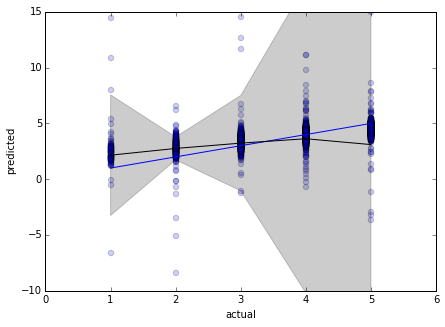

In [69]:
fig = plt.figure( figsize = [ 7, 5 ] )
df = pd.DataFrame( dict( actual = actual, predicted = predicted ) )
ax = plt.scatter( df['actual'], df['predicted'], alpha = 0.2, s = 30, label = "predicted" )
plt.plot( [1,5],[1,5], label = "slope 1")
plt.ylim( [ -10, 15 ] )
xp = [1,2,3,4,5]
yp = df.groupby('actual').predicted.mean().values
plt.plot( xp, yp, 'k', label = 'means')
sig = df.groupby('actual').predicted.std().values
plt.fill_between( xp, yp - sig, yp + sig, color = 'k', alpha = 0.2 )
plt.xlabel('actual')
plt.ylabel('predicted')
# plt.title('k = %s, reg = %s" % ( k , reg ) )
plt.show()

**2.4** For each review in the data set, obtain a prediction from the entire dataframe `smalldf`. Use the function `compare_results` above to plot the predicted ratings against the observed ones. Make 4 such graphs, at k=3 and k=10, and for reg=3. and reg=15.

Note that this analysis is not strictly a model check because we are testing on the training set. However, since the user averages would change each time a cross-validation split was done on the set, we would incur the prohibitive expense of redoing the database each time. This would be better done on a cluster, using map-reduce or other techniques. While we explore map-reduce later in this homework, we shall not do any cross-validation.

Explain the results you get in the graphs in words.